In [1]:
from sklearn.model_selection import cross_val_score, GroupKFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
import shap
import pickle
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time

# Data For

In [2]:
#data_for = '_PredMP'

data_for = '_ExpMP'

#data_for = '_NoMP'

In [3]:
black = '#515265'
red = '#DD706E'
yellow = '#FAAF3A'
blue = '#3A93C2'

In [4]:
file_path = '../../Exp_2_Dataset_feature_engineering/Summary_and_dataset/refined_dataset' + data_for + '.csv'

data = pd.read_csv(file_path)
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']
lab = data[data['Type'] == 'Lab']

In [5]:
overlapping_values = set(train['Drug-solvent system']).intersection(test['Drug-solvent system'])
overlapping_values

set()

In [6]:
def data_processing (dataset):

    X = dataset.drop(['Type', 'Drug', 'Solvent_1', 'Solvent_2', 'Drug-solvent system', 'LogS', 'Class', 'Solubility (g/100g)'], axis = 1)
    Y = dataset['LogS']
    G = dataset['Drug-solvent system']

    return X, Y, G

In [7]:
X_train, Y_train, G_train = data_processing(train)
X_test, Y_test, G_test = data_processing(test)
X_lab, Y_lab, G_lab = data_processing(lab)

In [8]:
X_train.shape

(19896, 362)

# Hyperparameter screening

In [9]:
search_spaces = {
    "DT": {
        "max_depth": Integer(3, 20),
        "splitter":Categorical(['best', 'random']),
        "min_samples_split": Real(0.01, 0.1),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical(['auto', 'sqrt', 'log2']),
    },
    "RF": {
        "n_estimators": Integer(10, 400),
        "max_depth": Integer(3, 20),
        "min_samples_split": Real(0.01, 0.1),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical(['auto', 'sqrt', 'log2']),
        "bootstrap": Categorical([True, False]),
    },
    "XGB": {
        "n_estimators": Integer(10, 400),
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "max_depth": Integer(3, 20),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.5, 1.0),
        "gamma": Real(0, 5),
    },
    "NN": {
        "hidden_layer_sizes": Integer(2, 64),
        "alpha": Real(0.0001, 0.1, prior="log-uniform"),
        "learning_rate_init": Real(0.001, 0.1, prior="log-uniform"),
        "activation": Categorical(['relu', 'tanh', 'logistic']),
},

    "LightGBM": {
        "num_leaves": Integer(10, 400),
        "max_depth": Integer(3, 20),
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "n_estimators": Integer(100, 1000),
        "bagging_fraction": Real(0.5, 1),
        "feature_fraction": Real(0.5, 1),
        "min_child_samples": Integer(5, 100),
    },
    "MLR": {
        'fit_intercept':Categorical([True, False]),
        'positive':Categorical([True, False])
    },
    "Lasso": {
        "alpha": Real(0.0001, 1, prior="log-uniform"),
        "selection": Categorical(['cyclic', 'random']),
    },
    "kNN": {'n_neighbors':Integer(2, 50),
            'weights': Categorical(["uniform", 'distance']),
            'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': Integer(10, 100),
            'p':Integer(1, 2),
    },
    "PLS": {'n_components':Integer(2, 6),
            'max_iter': Integer(250, 1000)
    }
    
}


In [10]:
search_spaces_df = pd.DataFrame([(model, params) for model, params in search_spaces.items()], columns=['Model', 'Hyperparameters'])

search_spaces_df.to_excel('Table_SI_search_space.xlsx', index = False)

In [11]:
models = {
    "DT": DecisionTreeRegressor(random_state=0),
    "RF": RandomForestRegressor(random_state=0, n_jobs=6),
    "XGB": XGBRegressor(random_state=0, n_jobs=6),
    "NN": MLPRegressor(random_state=0),
    "LightGBM": lgb.LGBMRegressor(random_state=0, n_jobs=6),
    "MLR": LinearRegression(),
    "Lasso": Lasso(),
    "PLS": PLSRegression(),
    "kNN": KNeighborsRegressor(n_jobs=6)}

In [12]:
def perform_hp_screening(model_name, X_train, Y_train, G_train, n_iter):

    
    model = models[model_name]
    search_space = search_spaces[model_name]
    
    
    cv = GroupKFold(n_splits=10)

    
    bscv = BayesSearchCV(
        estimator=model,
        search_spaces=search_space,
        scoring='neg_mean_absolute_error',
        cv=cv,
        n_iter=n_iter,
        n_jobs=6,
        verbose=0,
        random_state = 0
    )

    
    bscv.fit(X_train, Y_train, groups=G_train)
    optimization_history = bscv.cv_results_


    
    return bscv.best_estimator_, bscv.best_params_, bscv.best_score_, optimization_history


In [14]:
#model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "MLR", "Lasso", "PLS", "kNN"]

model_names = ["LightGBM", "XGB"]
results = {}

n_iter = 100


In [15]:
#model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "MLR", "Lasso", "PLS", "kNN"]

model_names = ["DT", "RF", "NN", "MLR", "Lasso", "PLS", "kNN"]


results = {}

n_iter = 100


In [16]:
for model_name in model_names:
    result = {}

    start = time.time()
    search_space = search_spaces[model_name]
    best_model, best_params, best_score, history = perform_hp_screening(model_name, X_train, Y_train, G_train, n_iter)
    end = time.time()
    
    print()
    print(model_name, ':  ', round(best_score,3))
    print(round((end-start)/60, 1), 'min')
    print()
    
    # Storing the results in a dictionary
    result[model_name] = {
        'best_estimator': best_model,
        'best_params': best_params,
        'best_score': best_score,
        'optimization_history': history
    }

    pickle_file_path = 'Results/' + model_name + '_BSCV_results' + data_for + '.pkl'

    with open(pickle_file_path, 'wb') as handle:
        pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and w


DT :   -0.485
3.4 min



/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

KeyboardInterrupt: 

In [16]:
model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "MLR", "Lasso", "PLS", "kNN"]

In [17]:
results = {}

for model_name in model_names:

    pickle_file_path = 'Results/' + model_name + '_BSCV_results' + data_for + '.pkl'
    
    with open(pickle_file_path, 'rb') as handle:
        result = pickle.load(handle)
        
    results[model_name] = {
        'best_estimator': result[model_name]['best_estimator'],
        'best_params': result[model_name]['best_params'],
        'best_score': result[model_name]['best_score'],
        'optimization_history': result[model_name]['optimization_history']
    }

Trying to unpickle estimator DecisionTreeRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LinearRegression from version 1.1.3 when using version 1.1.2. This might lead to breaking code or 

In [18]:
combined_pickle_file_path = 'Results/BSCV_results' + data_for + '.pkl'



In [19]:
with open(combined_pickle_file_path, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:

with open(combined_pickle_file_path, 'rb') as handle:
    results = pickle.load(handle)

In [21]:
model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "Lasso", "PLS", "kNN"]

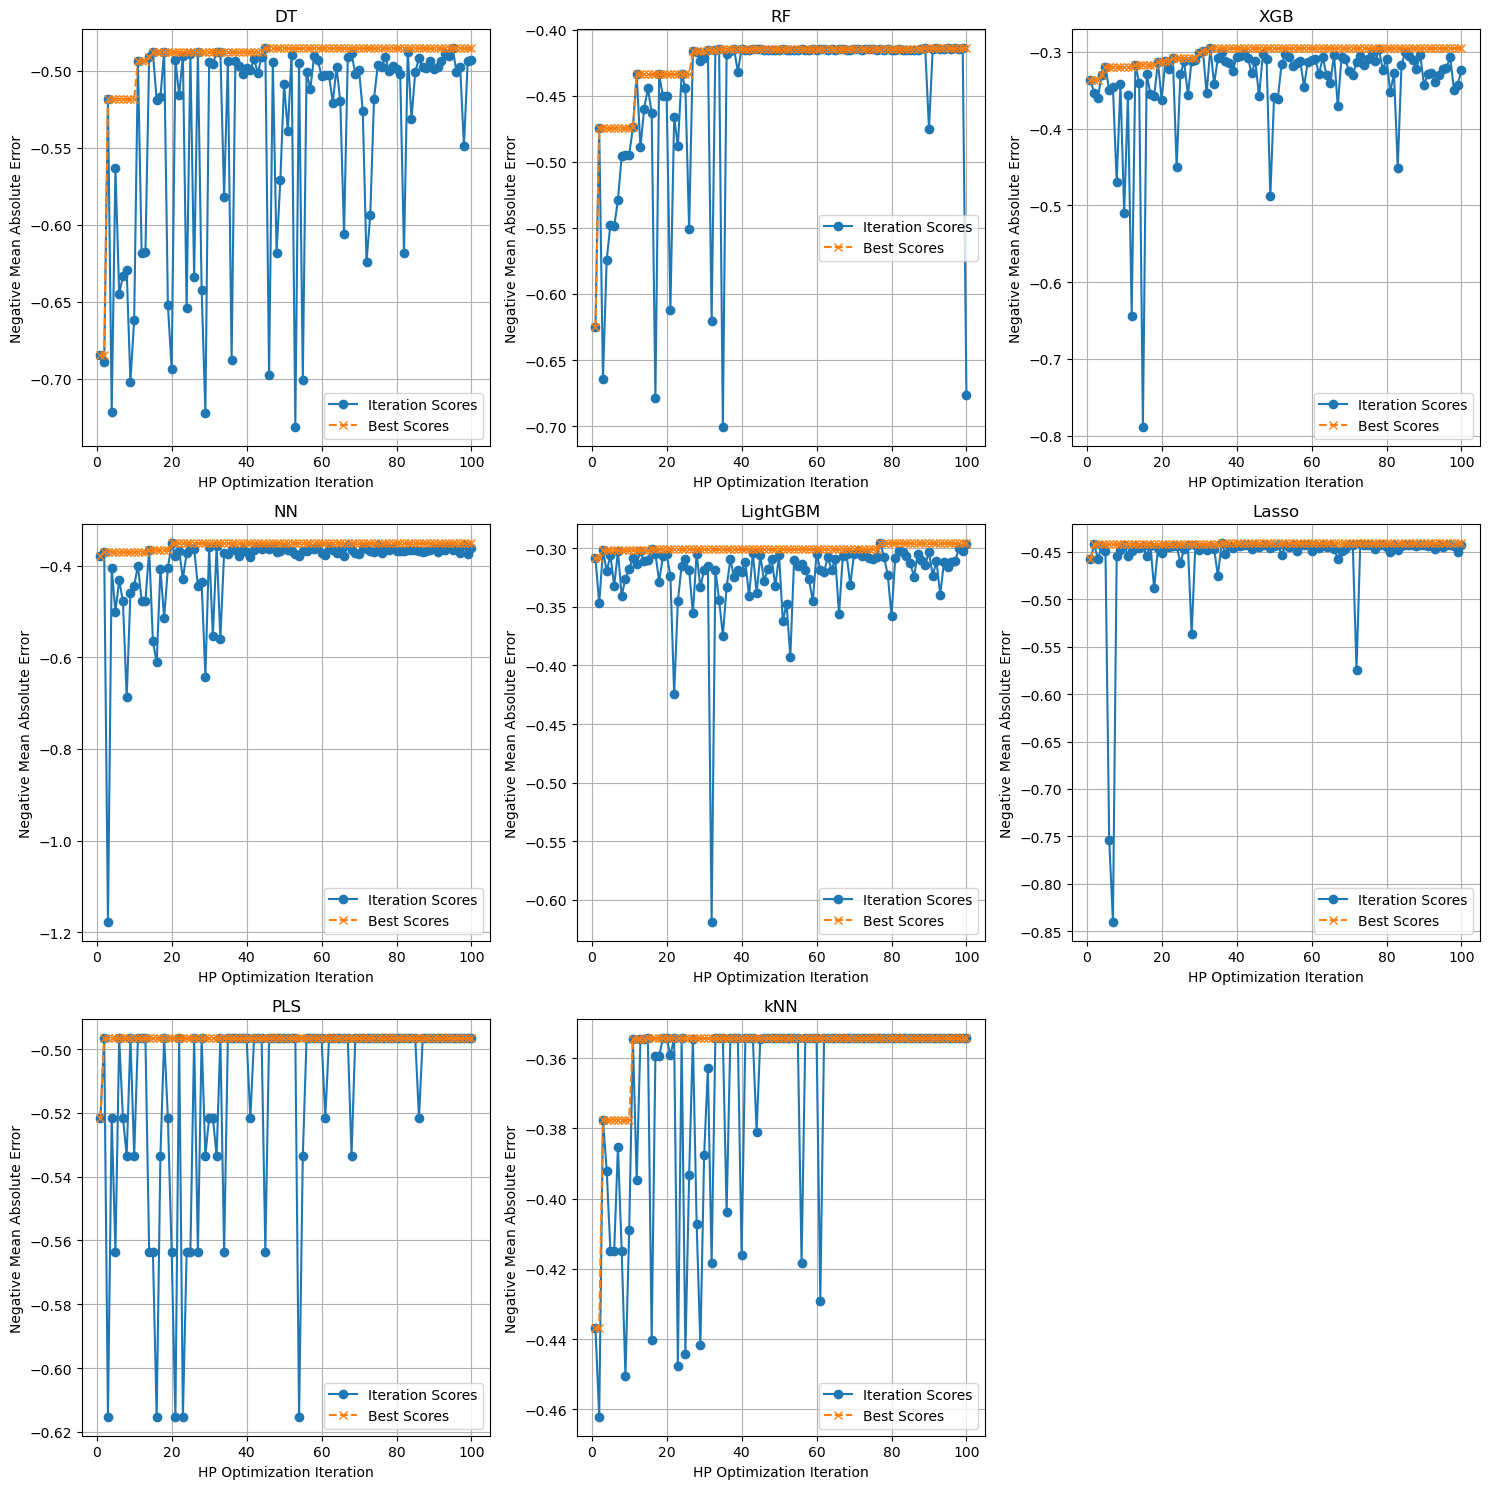

In [22]:

fig, axs = plt.subplots(3, 3, figsize=(15, 15))


for idx, model_name in enumerate(model_names):
    optimization_history = results[model_name]['optimization_history']

    scores = optimization_history['mean_test_score']
    iterations = range(1, len(scores) + 1)

    best_scores = np.maximum.accumulate(scores)

    ax = axs[idx // 3, idx % 3]  
    ax.plot(iterations, scores, marker='o', label='Iteration Scores')
    ax.plot(iterations, best_scores, marker='x', linestyle='--', label='Best Scores')
    ax.set_xlabel('HP Optimization Iteration')
    ax.set_ylabel('Negative Mean Absolute Error')
    ax.set_title(model_name)
    ax.legend()
    ax.grid(True)

for ax in axs.flatten()[len(model_names):]:
    ax.set_visible(False)

plt.tight_layout()


fig.savefig('Optimization_history' + data_for + '.png', dpi=300, format='png', transparent=True)

plt.show()

In [23]:
optimized_HP_df = pd.DataFrame([(model, best_params) for model, best_params in results.items()], columns=['Model', 'Best Hyperparameter'])
optimized_HP_df.to_excel('Table_SI_optimized_HP' + data_for + '.xlsx', index = False)




# Model evaluation using the literature test set

In [24]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = ['MAE', 'MedAE', 'RMSE', 'MSE', 'PCC', 'SCC']
train_summary = pd.DataFrame(index=metrics, columns=model_names)
test_summary = pd.DataFrame(index=metrics, columns=model_names)
predictions = pd.DataFrame(columns=model_names)

for model_name in model_names:
    model = results[model_name]['best_estimator']

    cv = GroupKFold(n_splits=10)
    Y_pred_train = cross_val_predict(model, X_train, Y_train, cv=cv, groups=G_train, n_jobs=6)

    Y_train = np.ravel(Y_train)
    Y_pred_train = np.ravel(Y_pred_train)
    
    train_summary[model_name]['MAE'] = mean_absolute_error(Y_train, Y_pred_train)
    train_summary[model_name]['MedAE'] = np.median(abs(Y_train - Y_pred_train))
    train_summary[model_name]['RMSE'] = rmse(Y_train, Y_pred_train)
    train_summary[model_name]['MSE'] = mean_squared_error(Y_train, Y_pred_train)
    train_summary[model_name]['PCC'] = pearsonr(Y_train, Y_pred_train)[0]
    train_summary[model_name]['SCC'] = spearmanr(Y_train, Y_pred_train)[0]


    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    
    Y_pred_test = np.ravel(Y_pred_test)
    
    test_summary[model_name]['MAE'] = mean_absolute_error(Y_test, Y_pred_test)
    test_summary[model_name]['MedAE'] = np.median(abs(Y_test - Y_pred_test))
    test_summary[model_name]['RMSE'] = rmse(Y_test, Y_pred_test)
    test_summary[model_name]['MSE'] = mean_squared_error(Y_test, Y_pred_test)
    test_summary[model_name]['PCC'] = pearsonr(Y_test, Y_pred_test)[0]
    test_summary[model_name]['SCC'] = spearmanr(Y_test, Y_pred_test)[0]
    
    predictions[model_name] = Y_pred_test

/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and w

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e+01, tolerance: 1.917e+00
  model = cd_fast.enet_coordinate_descent(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.123e+01, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [25]:
train_summary

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
MAE,0.48524,0.414097,0.295259,0.350703,0.295764,0.441814,0.496596,0.354394
MedAE,0.350094,0.309352,0.209967,0.250678,0.209336,0.326395,0.3917,0.205094
RMSE,0.675411,0.567466,0.422427,0.502932,0.419667,0.623329,0.654004,0.558103
MSE,0.456181,0.322018,0.178444,0.25294,0.17612,0.38854,0.427721,0.311479
PCC,0.774046,0.836673,0.913646,0.878205,0.914355,0.80984,0.781984,0.854242
SCC,0.739492,0.816389,0.902281,0.867254,0.900462,0.798331,0.754119,0.8353


In [26]:
test_summary

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
MAE,0.489743,0.435366,0.332023,0.413719,0.325964,0.513929,0.494762,0.412669
MedAE,0.336304,0.29164,0.212493,0.295038,0.229219,0.362909,0.385782,0.252788
RMSE,0.701146,0.622361,0.499017,0.610028,0.477304,0.714837,0.679817,0.64487
MSE,0.491606,0.387334,0.249018,0.372134,0.227819,0.510992,0.462151,0.415857
PCC,0.77278,0.816662,0.887303,0.834367,0.897994,0.770189,0.774027,0.822838
SCC,0.749701,0.801037,0.871144,0.794844,0.875044,0.729705,0.758871,0.784824


In [27]:
test_AE = predictions.copy()

test_AE['Y'] = Y_test.values

for model_name in model_names:
    test_AE[model_name] = abs(test_AE[model_name] - test_AE['Y'])
    
test_AE = test_AE.drop(['Y'], axis = 1)    
test_AE

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
0,0.874075,0.133114,0.008623,0.461557,0.218126,0.244932,0.210878,0.749000
1,0.739134,0.010445,0.141219,0.635505,0.010277,0.448656,0.503305,0.309720
2,0.880901,0.516042,0.367680,0.369543,0.449735,0.474686,0.524028,0.992905
3,0.949665,0.584806,0.428460,0.411276,0.458416,0.420350,0.485393,0.983547
4,0.594809,0.429677,0.318134,0.003235,0.390370,0.542198,0.550349,1.019261
...,...,...,...,...,...,...,...,...
6805,0.047901,0.226247,0.044349,0.315464,0.033343,0.761664,0.622124,0.087102
6806,0.104917,0.320015,0.073524,0.371841,0.008616,0.791383,0.667543,0.125999
6807,0.210455,0.425553,0.057070,0.419257,0.043628,0.773821,0.665682,0.133552
6808,0.622651,0.071116,0.203756,0.218971,0.258051,0.433113,0.262172,0.125739


In [28]:
for column in train_summary.columns:
    train_summary[column] = train_summary[column].astype(float)
    test_summary[column] = test_summary[column].astype(float)

In [29]:
train_summary_round = train_summary.round(3)
test_summary_round = test_summary.round(3)

In [30]:
train_summary_round

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
MAE,0.485,0.414,0.295,0.351,0.296,0.442,0.497,0.354
MedAE,0.350,0.309,0.210,0.251,0.209,0.326,0.392,0.205
RMSE,0.675,0.567,0.422,0.503,0.420,0.623,0.654,0.558
MSE,0.456,0.322,0.178,0.253,0.176,0.389,0.428,0.311
PCC,0.774,0.837,0.914,0.878,0.914,0.810,0.782,0.854
SCC,0.739,0.816,0.902,0.867,0.900,0.798,0.754,0.835


In [31]:
test_summary_round

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
MAE,0.490,0.435,0.332,0.414,0.326,0.514,0.495,0.413
MedAE,0.336,0.292,0.212,0.295,0.229,0.363,0.386,0.253
RMSE,0.701,0.622,0.499,0.610,0.477,0.715,0.680,0.645
MSE,0.492,0.387,0.249,0.372,0.228,0.511,0.462,0.416
PCC,0.773,0.817,0.887,0.834,0.898,0.770,0.774,0.823
SCC,0.750,0.801,0.871,0.795,0.875,0.730,0.759,0.785


In [32]:
test_summary_round_T = test_summary_round.T
test_summary_round_T

,MAE,MedAE,RMSE,MSE,PCC,SCC
DT,0.490,0.336,0.701,0.492,0.773,0.750
RF,0.435,0.292,0.622,0.387,0.817,0.801
XGB,0.332,0.212,0.499,0.249,0.887,0.871
NN,0.414,0.295,0.610,0.372,0.834,0.795
LightGBM,0.326,0.229,0.477,0.228,0.898,0.875
Lasso,0.514,0.363,0.715,0.511,0.770,0.730
PLS,0.495,0.386,0.680,0.462,0.774,0.759
kNN,0.413,0.253,0.645,0.416,0.823,0.785


In [33]:
sorted_models_ind = test_summary_round_T.sort_values(by="MAE", ascending=True).index
sorted_models = test_summary_round_T.loc[sorted_models_ind]
sorted_models



,MAE,MedAE,RMSE,MSE,PCC,SCC
LightGBM,0.326,0.229,0.477,0.228,0.898,0.875
XGB,0.332,0.212,0.499,0.249,0.887,0.871
kNN,0.413,0.253,0.645,0.416,0.823,0.785
NN,0.414,0.295,0.610,0.372,0.834,0.795
RF,0.435,0.292,0.622,0.387,0.817,0.801
DT,0.490,0.336,0.701,0.492,0.773,0.750
PLS,0.495,0.386,0.680,0.462,0.774,0.759
Lasso,0.514,0.363,0.715,0.511,0.770,0.730


In [34]:
test_AE = test_AE[sorted_models_ind]
test_AE

,LightGBM,XGB,kNN,NN,RF,DT,PLS,Lasso
0,0.218126,0.008623,0.749000,0.461557,0.133114,0.874075,0.210878,0.244932
1,0.010277,0.141219,0.309720,0.635505,0.010445,0.739134,0.503305,0.448656
2,0.449735,0.367680,0.992905,0.369543,0.516042,0.880901,0.524028,0.474686
3,0.458416,0.428460,0.983547,0.411276,0.584806,0.949665,0.485393,0.420350
4,0.390370,0.318134,1.019261,0.003235,0.429677,0.594809,0.550349,0.542198
...,...,...,...,...,...,...,...,...
6805,0.033343,0.044349,0.087102,0.315464,0.226247,0.047901,0.622124,0.761664
6806,0.008616,0.073524,0.125999,0.371841,0.320015,0.104917,0.667543,0.791383
6807,0.043628,0.057070,0.133552,0.419257,0.425553,0.210455,0.665682,0.773821
6808,0.258051,0.203756,0.125739,0.218971,0.071116,0.622651,0.262172,0.433113


In [35]:
test_summary_round = test_summary_round[sorted_models_ind]
test_summary_round.to_excel('Figure_3b' + data_for + '.xlsx', index = True)
test_summary_round

,LightGBM,XGB,kNN,NN,RF,DT,PLS,Lasso
MAE,0.326,0.332,0.413,0.414,0.435,0.490,0.495,0.514
MedAE,0.229,0.212,0.253,0.295,0.292,0.336,0.386,0.363
RMSE,0.477,0.499,0.645,0.610,0.622,0.701,0.680,0.715
MSE,0.228,0.249,0.416,0.372,0.387,0.492,0.462,0.511
PCC,0.898,0.887,0.823,0.834,0.817,0.773,0.774,0.770
SCC,0.875,0.871,0.785,0.795,0.801,0.750,0.759,0.730


In [36]:
train_summary_round = train_summary_round[sorted_models_ind]
train_summary_round.to_excel('Figure_SI_training_results' + data_for + '.xlsx', index = True)
train_summary_round

,LightGBM,XGB,kNN,NN,RF,DT,PLS,Lasso
MAE,0.296,0.295,0.354,0.351,0.414,0.485,0.497,0.442
MedAE,0.209,0.210,0.205,0.251,0.309,0.350,0.392,0.326
RMSE,0.420,0.422,0.558,0.503,0.567,0.675,0.654,0.623
MSE,0.176,0.178,0.311,0.253,0.322,0.456,0.428,0.389
PCC,0.914,0.914,0.854,0.878,0.837,0.774,0.782,0.810
SCC,0.900,0.902,0.835,0.867,0.816,0.739,0.754,0.798


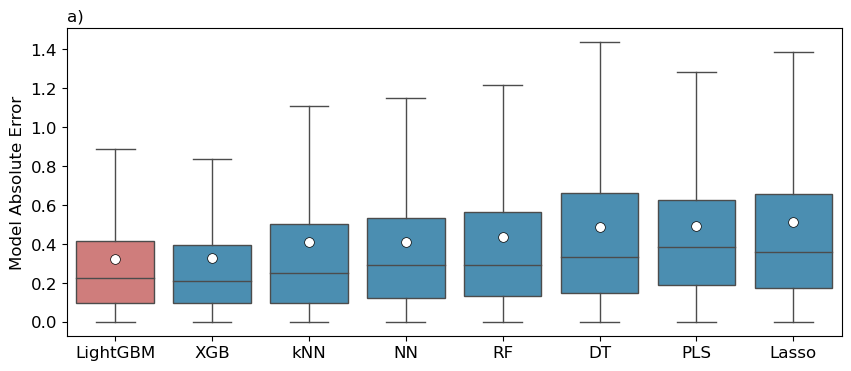

In [40]:

plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 12})


palette = [red] + [blue] * (len(test_AE.columns) - 1)


sns.boxplot(data=test_AE, palette=palette, showfliers=False, showmeans=True,linewidth = 1.0, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"white", "markersize": 7, "markeredgewidth": 0.5, "markeredgecolor": "black"})

        
plt.title('')
plt.ylabel('Model Absolute Error')

plt.annotate('a)', xy=(0, 1.06), xycoords="axes fraction", va="top", ha="left", fontsize=12)
plt.savefig('Figure_3a_Model_test_boxplots' + data_for + '.png', transparent=True, dpi=300)

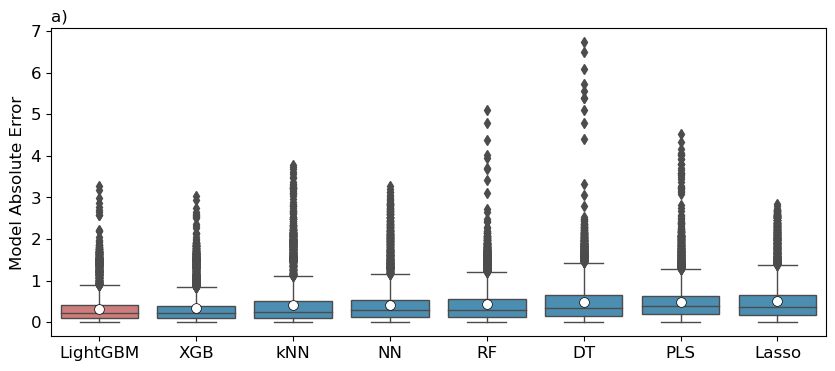

In [41]:

plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 12})


palette = [red] + [blue] * (len(test_AE.columns) - 1)


sns.boxplot(data=test_AE, palette=palette, showfliers=True, showmeans=True,linewidth = 1.0, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"white", "markersize": 7, "markeredgewidth": 0.5, "markeredgecolor": "black"})


        
plt.title('')
plt.ylabel('Model Absolute Error')

plt.annotate('a)', xy=(0, 1.06), xycoords="axes fraction", va="top", ha="left", fontsize=12)
plt.savefig('Figure_SI_model_test_boxplots_with_outliers' + data_for + '.png', transparent=True, dpi=300)